# 5. Analysis

Time for some machine learning!

In [3]:
# set up some dependencies
import json, time, random, csv
import numpy as np
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import descartes # for plotting with geopanadas

In [4]:
# set up path to app credentials - see exploration/README.md
%env GOOGLE_APPLICATION_CREDENTIALS=../google_app_credentials.json

# set up bigquery client
from google.cloud import bigquery
bq = bigquery.Client()

env: GOOGLE_APPLICATION_CREDENTIALS=../google_app_credentials.json


In [5]:
# grab valid years and check BigQuery connection
resp = bq.query('''
    SELECT DISTINCT do_date AS year
    FROM `eosc410-project.data.acs_cbsa_20*`
    ORDER BY do_date ASC
''')
years = [row["year"] for row in resp]

In [6]:
'''
Gets the GeoID from the combined ID
'''
def combined_id_to_geoid(combined_id: str) -> str:
    parts = combined_id.split('.')
    if len(parts) < 1:
        return ''
    return parts[0]
def combined_id_to_epa_param(combined_id: str) -> str:
    parts = combined_id.split('.')
    if len(parts) < 3:
        return ''
    return parts[len(parts)-1]

In [7]:
# load up aggregated data - refer to _data/acs/README.md and _data/epa/README.md
acs_ts_flat = pd.read_csv('../docs/_data/acs/timeseries_flat.csv')
acs_ts_vert = pd.read_csv('../docs/_data/acs/timeseries_vert.csv')
acs_ts_vert_alt = pd.read_csv('../docs/_data/acs/timeseries_vert_alt.csv',index_col=0)
epa_ts_flat = pd.read_csv('../docs/_data/epa/timeseries_flat.csv')
epa_ts_vert = pd.read_csv('../docs/_data/epa/timeseries_vert.csv')

# take a peak at what's up
print('==== ACS Aggregates\n')
print(acs_ts_vert_alt.dtypes, '\n')
# print('==== EPA Aggregates\n')
# print(epa_ts_flat.dtypes, '\n')
# print(epa_ts_vert.dtypes, '\n')

==== ACS Aggregates

geoid                                        int64
2007.commute_10_29_mins                    float64
2007.commute_30_59_mins                    float64
2007.commute_over_60_mins                  float64
2007.commute_under_10_mins                 float64
                                            ...   
2018.rent_over_50_percent                  float64
2018.rent_under_25_percent                 float64
2018.some_college_and_associates_degree    float64
2018.total_pop                             float64
2018.walked_to_work                        float64
Length: 337, dtype: object 



In [8]:
resp = bq.query('''
SELECT DISTINCT(geo_id) AS geoid
FROM `eosc410-project.data.acs_cbsa_20*` # multi-table query
''')
geoids = [row["geoid"] for row in resp]
len(geoids)

557

In [129]:
# find epa value for corresponding geoids
epa_aggs = pd.DataFrame(data={'geoid': geoids})
for index, row in epa_aggs.iterrows():
    geoid = row['geoid']
    rows_with_geoid = epa_ts_vert[epa_ts_vert['combined_id'].str.startswith("%s." % geoid)]
    for param in ['88502', '68105']:
        # columns: [combined_id, year.stdev, year.mean, ...]
        # rows: combined_id with this geoid, param
        rows_with_param = rows_with_geoid[rows_with_geoid['combined_id'].str.endswith(".%s" % param)]
        rows_with_param['geoid'] = [geoid for i in range(len(rows_with_param))]

        # want:
        # columns: [geoid, year.mean, year.stdev]
        def rename_column(col):
            if col.startswith('2'):
                return '%s.%s' % (col, param)
            return col
        row_data = rows_with_param.dropna().groupby(['geoid']).mean().rename(columns=lambda col: rename_column(col))
        if len(row_data) > 0:
            for (col, data) in row_data.iteritems():
                epa_aggs.loc[index, col] = data.iloc[0]

print('\n===\nresults')
epa_aggs.head()

    # rows_with_param_combined= rows_with_param.groupby('combined_id').agg(np.mean) #group geoid and get mean of each column
    # print('\n%d measurements of parameter %s for geoid %s' % (len(rows_with_param), param, geoid))
    # print(rows_with_param[['2007.mean', '2007.stdev']].head())


===
results


,geoid,Unnamed: 0,2007.mean.88502,2007.stdev.88502,2008.mean.88502,2008.stdev.88502,2009.mean.88502,2009.stdev.88502,2010.mean.88502,2010.stdev.88502,...,2014.mean.68105,2014.stdev.68105,2015.mean.68105,2015.stdev.68105,2016.mean.68105,2016.stdev.68105,2017.mean.68105,2017.stdev.68105,2018.mean.68105,2018.stdev.68105
0,46180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
'''
Generate time series for given geoid
'''
def get_timeseries_for_geoid(geoid):
    epa_row = epa_aggs[epa_aggs.geoid==geoid]
    epa = pd.DataFrame(data={'year': years})
    for (col, vals) in epa_row.iteritems():
        if col.startswith('2'):
            year = col.split('.')[0]
            measurement = '%s.%s' % (col.split('.')[1], col.split('.')[2]) # 3-part combined id
            feature = '%s.epa.%s' % (geoid, measurement)
            row_index = epa.index[epa['year'] == year].tolist()[0] # should have single match
            epa.loc[row_index, feature] = vals.iloc[0] # should be single row
    print(epa.head())

    acs = acs_ts_flat[['year'] + [col for col in acs_ts_flat if col.startswith(geoid)]]
    print(acs.head())

    geoid_df = pd.concat([acs,epa])
    geoid_df = geoid_df.loc[:, ~geoid_df.columns.str.contains('^Unnamed')]
    return geoid_df

geoid = '41860'
print(get_timeseries_for_geoid(geoid).head())

year  41860.epa.mean.88502  41860.epa.stdev.88502  41860.epa.mean.68105  \
0  2007              5.341525               3.711114                   NaN   
1  2008              6.110345               3.890733                   NaN   
2  2009              5.256250               3.379103                   NaN   
3  2010              5.086087               3.431610                   NaN   
4  2011              5.492000               3.956268                   NaN   

   41860.epa.stdev.68105  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  
   year  41860.acs.commute_10_29_mins  41860.acs.commute_30_59_mins  \
0  2007                      872911.0                      808830.0   
1  2008                      929834.0                      849383.0   
2  2009                      909957.0                      826430.0   
3  2010                      887035.0                      825745.0   
4  2011          

In [127]:
# find epa value for corresponding geoids
aggregates = pd.DataFrame(data={'year': years})
for index, row in aggregates.iterrows():
    year = row['year']
    rows_with_geoid = epa_ts_flat[['year'] + [col for col in epa_ts_flat if col.startswith(geoid)]]
    for param in ['88502', '68105']:
        # columns: [combined_id, year.stdev, year.mean, ...]
        # rows: combined_id with this geoid, param
        rows_with_param = rows_with_geoid[rows_with_geoid['combined_id'].str.endswith(".%s" % param)]
        rows_with_param['geoid'] = [geoid for i in range(len(rows_with_param))]
        # print('\n===\n%d measurements of parameter %s for geoid %s' % (len(rows_with_param), param, geoid))
        # print(rows_with_param[['combined_id', '2007.mean', '2007.stdev']].head())

        # want:
        # columns: [geoid, year.mean, year.stdev]
        def rename_column(col):
            if col.startswith('2'):
                return '%s.%s' % (col, param)
            return col
        row_data = rows_with_param.dropna().groupby(['geoid']).mean().rename(columns=lambda col: rename_column(col))
        if len(row_data) > 0:
            for (col, data) in row_data.iteritems():
                aggregates.loc[index, col] = data.iloc[0]

print('\n===\nresults')
aggregates.head()


KeyError: 'combined_id'

In [117]:
geoid = '41860'
epa = epa_ts_flat[['year'] + [col for col in epa_ts_flat if col.startswith(geoid)]]
acs = acs_ts_flat[['year'] + [col for col in acs_ts_flat if col.startswith(geoid)]]

acs_bind_aggregates_41860 = pd.concat([acs,epa])
acs_bind_aggregates_41860 = acs_bind_aggregates_41860.loc[:, ~acs_bind_aggregates_41860.columns.str.contains('^Unnamed')] #remove unnamed group
acs_bind_aggregates_41860.head()

,41860.acs.commute_10_29_mins,41860.acs.commute_30_59_mins,41860.acs.commute_over_60_mins,41860.acs.commute_under_10_mins,41860.acs.commuters_by_car_truck_van,41860.acs.commuters_by_public_transportation,41860.acs.dwellings_20_to_49_units,41860.acs.dwellings_50_or_more_units,41860.acs.dwellings_5_to_19_units,41860.acs.dwellings_under_4_units,...,41860.epa.06.081.1001.68105.stdev,41860.epa.06.081.1001.88502.mean,41860.epa.06.081.1001.88502.stdev,41860.epa.06.081.2002.68105.mean,41860.epa.06.081.2002.68105.stdev,41860.epa.06.081.2003.68105.mean,41860.epa.06.081.2003.68105.stdev,41860.epa.06.081.2004.68105.mean,41860.epa.06.081.2004.68105.stdev,year
0,872911.0,808830.0,439970.0,340346.0,1484782.0,296434.0,110331.0,137161.0,212788.0,1209845.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007
1,929834.0,849383.0,450508.0,311717.0,1558839.0,308298.0,114349.0,140355.0,211743.0,1211154.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
2,909957.0,826430.0,415512.0,301775.0,1501272.0,304111.0,114277.0,143587.0,208030.0,1213755.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009
3,887035.0,825745.0,416036.0,288541.0,1477565.0,300081.0,119041.0,152884.0,221823.0,1229825.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
4,867248.0,837438.0,433996.0,285935.0,1465595.0,299204.0,110927.0,149315.0,223487.0,1242171.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011


In [124]:
epa

,year,41860.epa.06.001.0007.68105.mean,41860.epa.06.001.0007.68105.stdev,41860.epa.06.001.0007.88502.mean,41860.epa.06.001.0007.88502.stdev,41860.epa.06.001.0009.68105.mean,41860.epa.06.001.0009.68105.stdev,41860.epa.06.001.1001.68105.mean,41860.epa.06.001.1001.68105.stdev,41860.epa.06.001.2004.88502.mean,...,41860.epa.06.081.1001.88502.mean,41860.epa.06.081.1001.88502.stdev,41860.epa.06.001.0011.88502.mean,41860.epa.06.001.0011.88502.stdev,41860.epa.06.081.2002.68105.mean,41860.epa.06.081.2002.68105.stdev,41860.epa.06.081.2003.68105.mean,41860.epa.06.081.2003.68105.stdev,41860.epa.06.081.2004.68105.mean,41860.epa.06.081.2004.68105.stdev
0,2007,14.135556,5.651435,7.886455,6.885888,11.430000,2.632209,13.698901,4.075850,15.170000,...,9.913650,7.062075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008,13.528767,5.432989,10.175166,7.523201,13.542105,4.210084,14.601111,4.397867,12.834819,...,10.501950,6.521946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009,11.320952,4.711082,7.824851,5.145388,14.037705,3.825535,14.533333,4.208735,9.858953,...,9.930159,5.412024,9.293378,4.466656,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,11.779524,4.578210,6.293264,4.208518,NaN,NaN,NaN,NaN,8.787637,...,NaN,NaN,8.395930,4.858335,NaN,NaN,NaN,NaN,NaN,NaN
4,2011,8.187931,3.212589,7.821667,4.636410,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.596149,5.577470,NaN,NaN,NaN,NaN,NaN,NaN
5,2012,NaN,NaN,7.104918,4.507047,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.399970,4.930439,20.516327,3.195853,NaN,NaN,NaN,NaN
6,2013,NaN,NaN,9.231667,7.482805,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.318033,7.144007,20.651220,3.609025,16.253191,3.812328,NaN,NaN
7,2014,NaN,NaN,7.055738,6.081325,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.020339,4.853963,NaN,NaN,13.372727,2.526298,NaN,NaN
8,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.068085,4.427783
9,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.531148,4.421973


In [120]:
geoid = '41860'
aggregates_2 = aggregates[['year'] + [col for col in epa_ts_flat if col.startswith(geoid)]]
acs = acs_ts_flat[['year'] + [col for col in acs_ts_flat if col.startswith(geoid)]]

acs_bind_aggregates_41860 = pd.concat([acs,aggregates_2])
acs_bind_aggregates_41860 = acs_bind_aggregates_41860.loc[:, ~acs_bind_aggregates_41860.columns.str.contains('^Unnamed')] 
#remove unnamed group
acs_bind_aggregates_41860.head()

KeyError: "None of [Index(['year', '41860.epa.06.001.0007.68105.mean',\n       '41860.epa.06.001.0007.68105.stdev', '41860.epa.06.001.0007.88502.mean',\n       '41860.epa.06.001.0007.88502.stdev', '41860.epa.06.001.0009.68105.mean',\n       '41860.epa.06.001.0009.68105.stdev', '41860.epa.06.001.1001.68105.mean',\n       '41860.epa.06.001.1001.68105.stdev', '41860.epa.06.001.2004.88502.mean',\n       '41860.epa.06.001.2004.88502.stdev', '41860.epa.06.013.0002.68105.mean',\n       '41860.epa.06.013.0002.68105.stdev', '41860.epa.06.041.0002.88502.mean',\n       '41860.epa.06.041.0002.88502.stdev', '41860.epa.06.075.0005.68105.mean',\n       '41860.epa.06.075.0005.68105.stdev', '41860.epa.06.075.0005.88502.mean',\n       '41860.epa.06.075.0005.88502.stdev', '41860.epa.06.081.1001.68105.mean',\n       '41860.epa.06.081.1001.68105.stdev', '41860.epa.06.081.1001.88502.mean',\n       '41860.epa.06.081.1001.88502.stdev', '41860.epa.06.001.0011.88502.mean',\n       '41860.epa.06.001.0011.88502.stdev', '41860.epa.06.081.2002.68105.mean',\n       '41860.epa.06.081.2002.68105.stdev', '41860.epa.06.081.2003.68105.mean',\n       '41860.epa.06.081.2003.68105.stdev', '41860.epa.06.081.2004.68105.mean',\n       '41860.epa.06.081.2004.68105.stdev'],\n      dtype='object')] are in the [columns]"

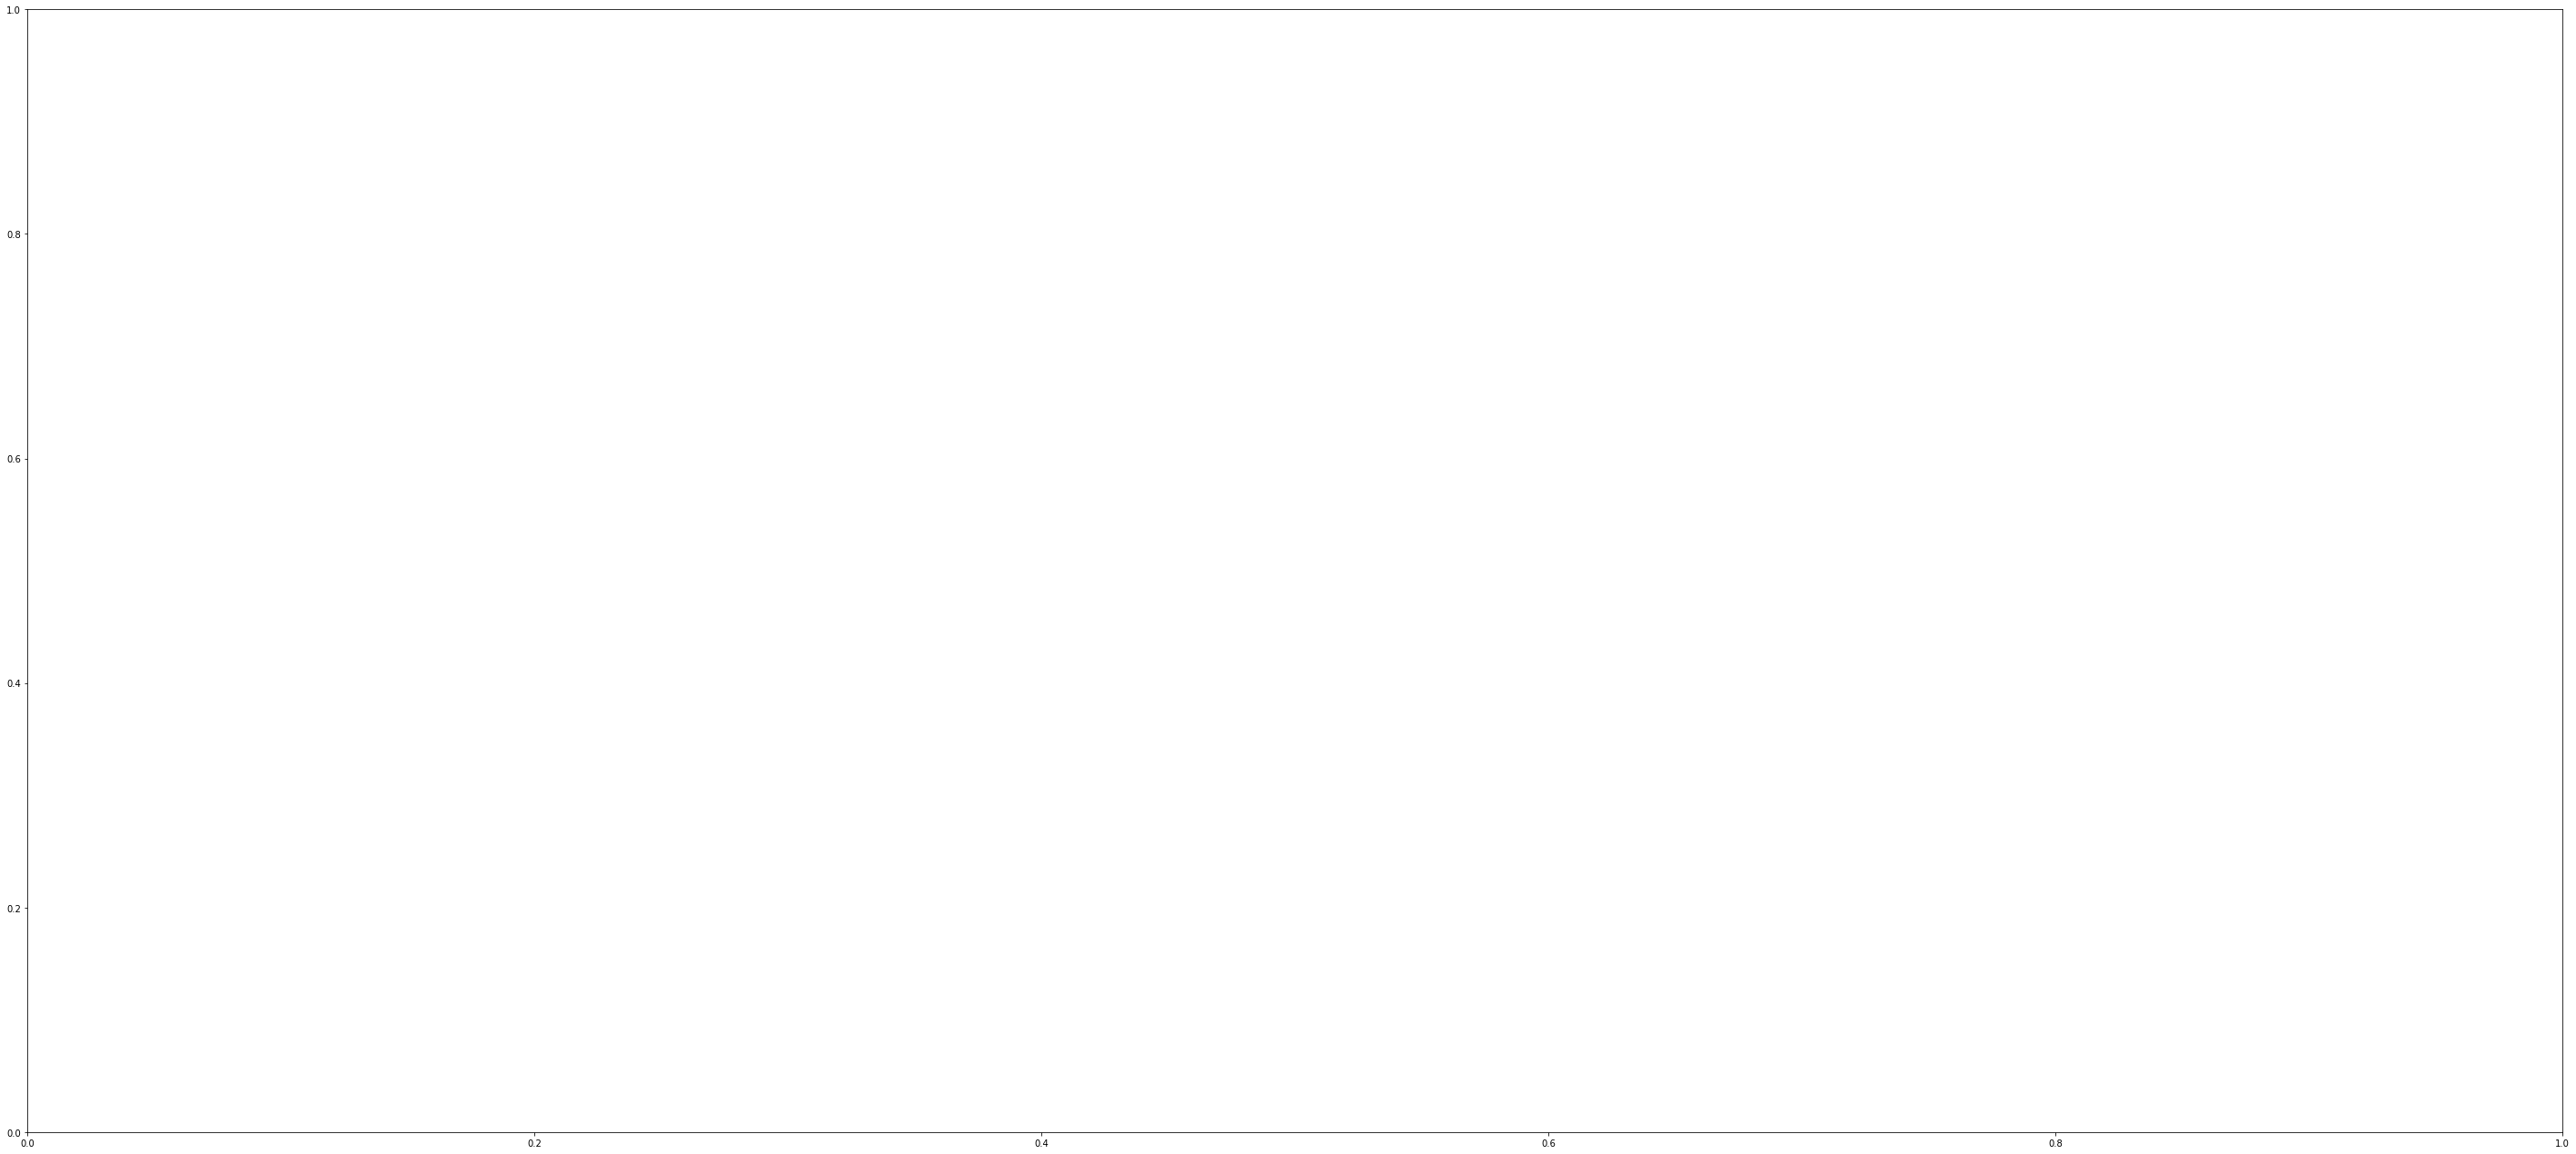

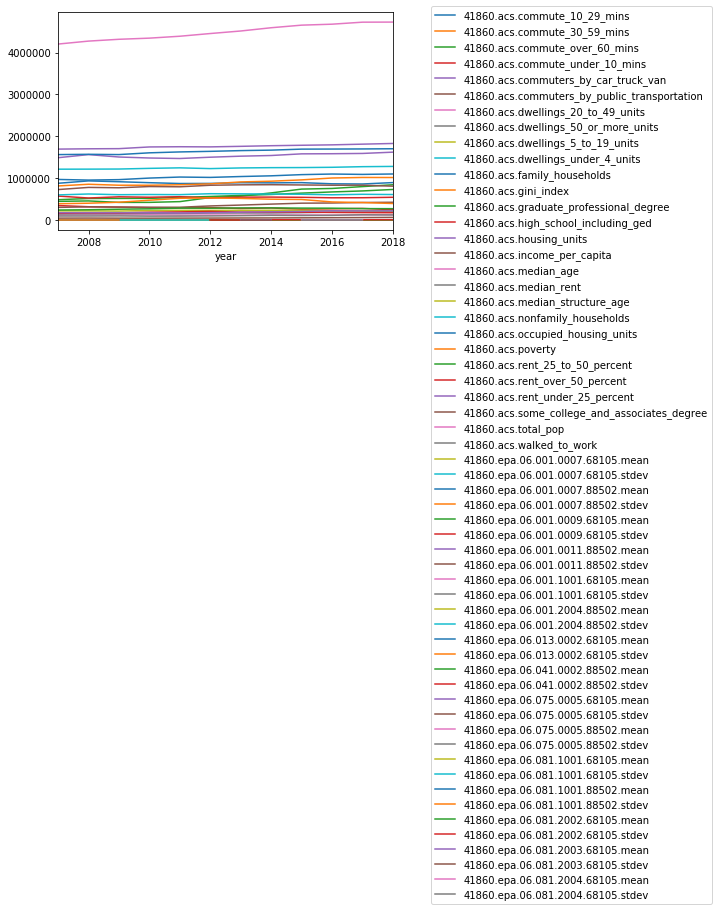

In [119]:
#visualize everything in the plot 
plt.figure(figsize=(50,50))
plt.subplot(2,1,1) #firrst subplot
acs_bind_aggregates_41860.set_index('year').plot()
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [ ]:
#plot the epa 
